In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils, callbacks
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

In [2]:
train_folder = 'C:/Users/subha/Downloads/ASL/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
1,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
2,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
3,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
4,A,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
...,...,...
86995,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86996,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86997,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...
86998,Z,C:/Users/subha/Downloads/ASL/asl_alphabet_trai...


In [3]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [4]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, zoom_range=0.2, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, horizontal_flip = True, vertical_flip=False)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False   
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [5]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

In [6]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [7]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(29, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                14877     
Total params: 27,774,493
Trainable params: 4,209,693
Non-trainable params: 23,564,800
_________________________________________________________________


In [9]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [10]:
classes = 29
epochs = 50
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True, callbacks = [earlystopping])

C:\Users\subha\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
490/490 [==============================] - 175s 346ms/step - loss: 2.3478 - accuracy: 0.3542 - val_loss: 1.2258 - val_accuracy: 0.6580
Epoch 2/50
490/490 [==============================] - 94s 192ms/step - loss: 1.5903 - accuracy: 0.5300 - val_loss: 0.9445 - val_accuracy: 0.7283
Epoch 3/50
490/490 [==============================] - 89s 183ms/step - loss: 1.3470 - accuracy: 0.5967 - val_loss: 0.8089 - val_accuracy: 0.7640
Epoch 4/50
490/490 [==============================] - 90s 183ms/step - loss: 1.2023 - accuracy: 0.6333 - val_loss: 0.7135 - val_accuracy: 0.7866
Epoch 5/50
490/490 [==============================] - 89s 182ms/step - loss: 1.1041 - accuracy: 0.6614 - val_loss: 0.6329 - val_accuracy: 0.8098
Epoch 6/50
490/490 [==============================] - 90s 183ms/step - loss: 1.0340 - accuracy: 0.6813 - val_loss: 0.5986 - val_accuracy: 0.8225
Epoch 7/50
490/490 [==============================] - 89s 182ms/step - loss: 0.9816 - accuracy: 0.6957 - val_loss: 0.5663 - val_a

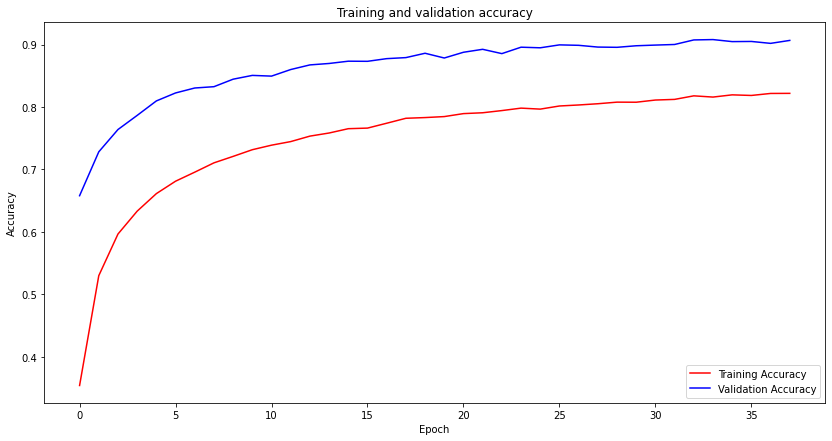

In [11]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

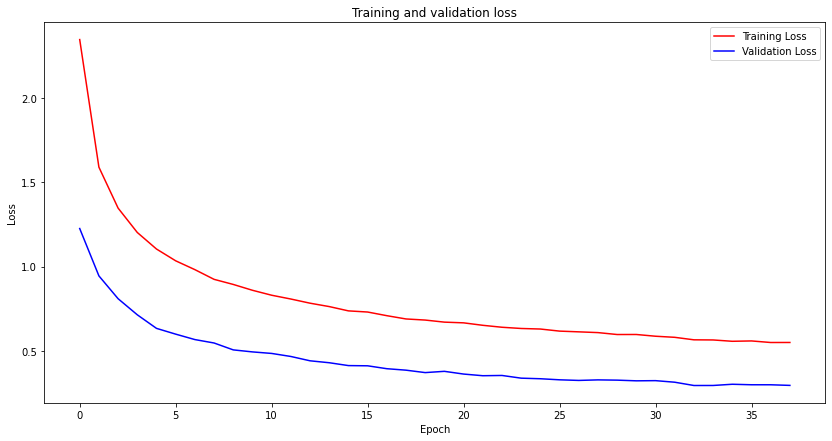

In [12]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [13]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

68/68 [==============================] - 33s 483ms/step
              precision    recall  f1-score   support

           A       0.93      0.92      0.93       300
           B       0.91      0.92      0.91       300
           C       0.98      0.97      0.97       300
           D       0.97      0.97      0.97       300
           E       0.89      0.85      0.87       300
           F       0.97      0.95      0.96       300
           G       0.93      0.87      0.90       300
           H       0.96      0.92      0.94       300
           I       0.93      0.87      0.90       300
           J       0.97      0.95      0.96       300
           K       0.92      0.87      0.90       300
           L       0.95      0.96      0.95       300
           M       0.84      0.90      0.87       300
           N       0.94      0.88      0.91       300
           O       0.98      0.96      0.97       300
           P       0.96      0.92      0.94       300
           Q       0.94  

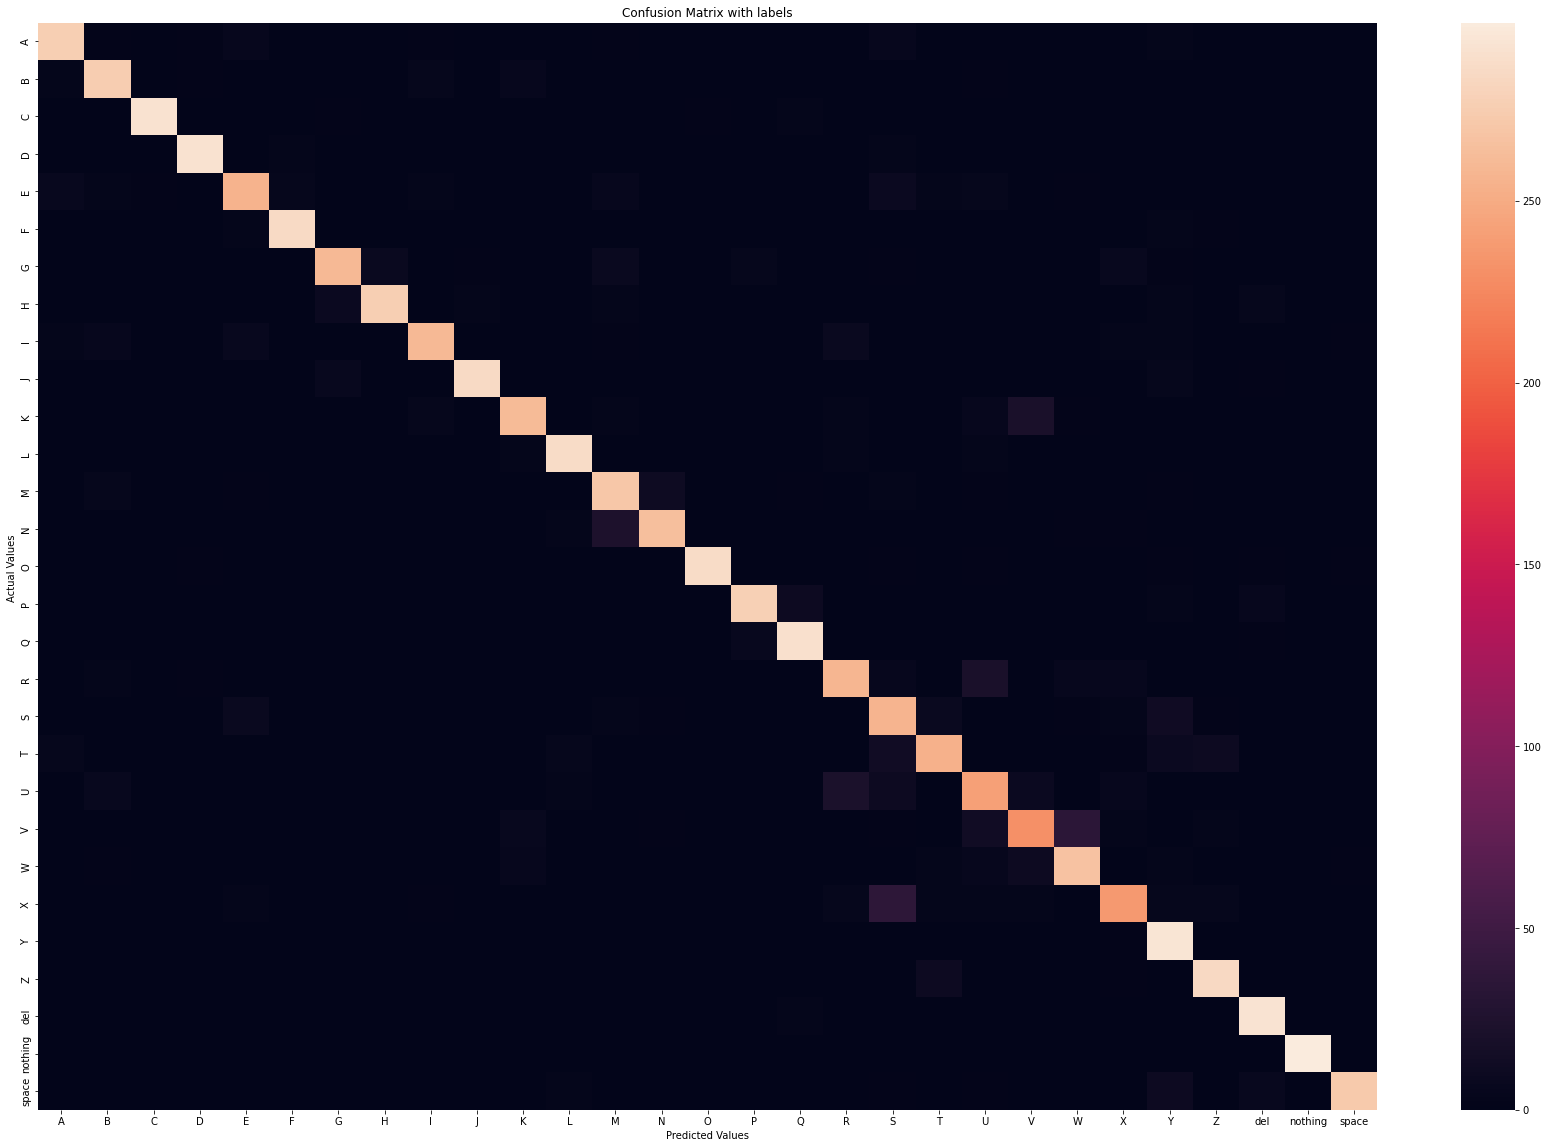

In [14]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [15]:
model.save('ResNet50V2-Aug.h5')

C:\Users\subha\anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [16]:
from keras.models import model_from_json
json_model = model.to_json()

with open('ResNet50V2-Aug.json', 'w') as json_file:
    json_file.write(json_model)

In [17]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[276   2   0   2   5   0   0   0   2   0   0   0   2   1   0   0   0   0
    5   0   0   0   0   0   3   1   0   0   1]
 [  3 275   0   2   1   0   1   1   4   0   5   0   1   0   0   0   0   0
    1   0   2   0   1   1   0   1   0   0   1]
 [  1   0 291   0   0   0   2   0   0   0   0   0   0   0   2   0   3   0
    0   0   0   0   0   0   0   0   1   0   0]
 [  0   0   1 291   0   3   0   0   0   0   1   0   0   0   1   0   0   0
    3   0   0   0   0   0   0   0   0   0   0]
 [  7   3   2   0 255   4   0   0   3   0   0   0   5   0   1   0   0   0
    9   3   4   0   2   0   1   0   0   0   1]
 [  0   0   0   0   3 286   0   0   1   0   1   1   1   0   0   0   0   0
    0   0   1   0   0   0   3   2   0   0   1]
 [  0   0   1   0   1   1 260   8   0   2   0   1   8   0   0   4   0   1
    2   0   1   0   0   7   2   0   0   0   1]
 [  0   0   0   0   0   0   9 276   0   3   0   0   3   0   0   1   0   0
    0   0   0   0   0   0   3   0   4   0   1]
 [  3   5   1 

<AxesSubplot:>

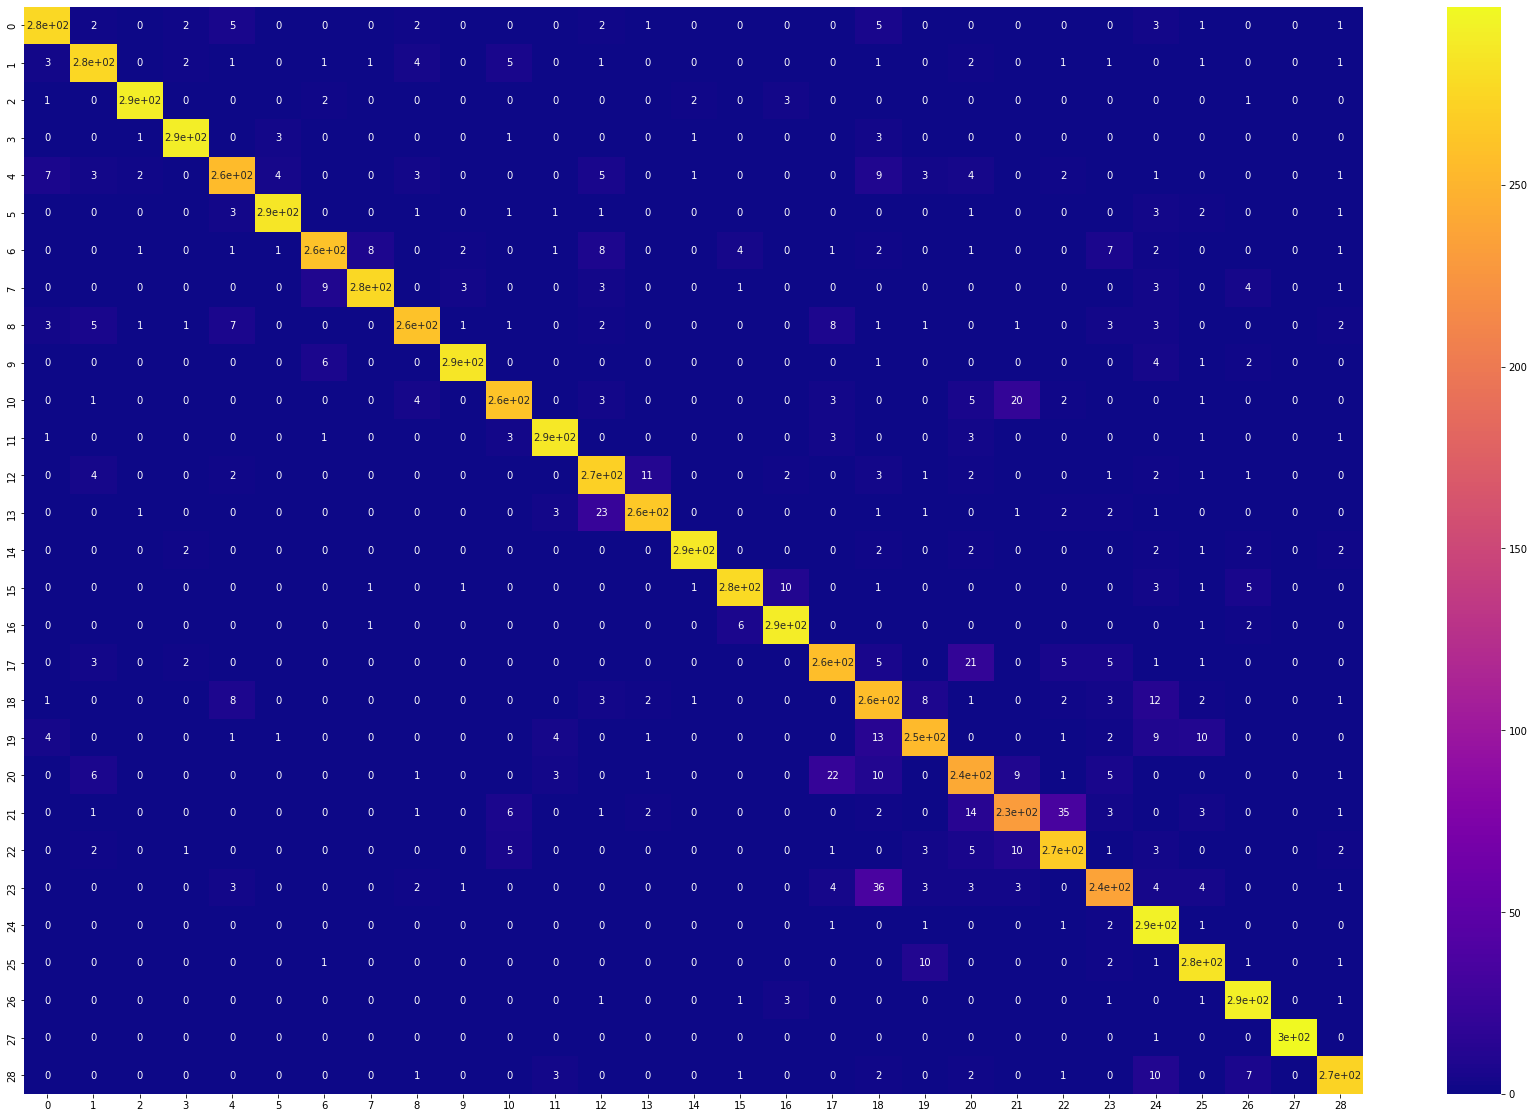

In [18]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)